In [32]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
def model_evaluation_CV(mdl, df, train_df, feature_col, label_col, n=5, normalize=False):
    # Evaluate model accuracy using Stratified K-fold CV
    # Note: Stratification is based on patient group (A, B, C), and then samples are formed
    skf = StratifiedKFold(n_splits=n)
    acc_train, acc_val = [], []
    for idx_train, idx_val in skf.split(train_df, train_df['group']):
        file_train, file_val = train_df.loc[idx_train, 'file'], train_df.loc[idx_val, 'file']
        X_train, X_val = df.loc[df.file.isin(file_train), feature_col], df.loc[df.file.isin(file_val), feature_col]
        y_train, y_val = df.loc[df.file.isin(file_train), label_col], df.loc[df.file.isin(file_val), label_col]
        
        if normalize:
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)

        mdl.fit(X_train, y_train)
        acc_train.append(metrics.accuracy_score(y_train, mdl.predict(X_train)))
        acc_val.append(metrics.accuracy_score(y_val, mdl.predict(X_val)))

    return np.mean(acc_train), np.mean(acc_val)

In [24]:
df = pd.read_csv('features/feature.csv')
train_df = pd.read_csv('resources\File_train.csv')
feature_col = df.drop(labels=['apn', 'group', 'file'], axis=1).columns
label_col = 'apn'

file_train, file_val = train_test_split(
    train_df['file'], random_state=123, test_size=0.2, stratify=train_df['group'])
X_train, X_val = df.loc[df.file.isin(
    file_train), feature_col], df.loc[df.file.isin(file_val), feature_col]
y_train, y_val = df.loc[df.file.isin(
    file_train), label_col], df.loc[df.file.isin(file_val), label_col]

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

train accuracy: 0.85479 
valid accuracy: 0.7953 



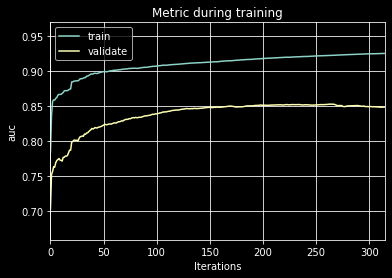

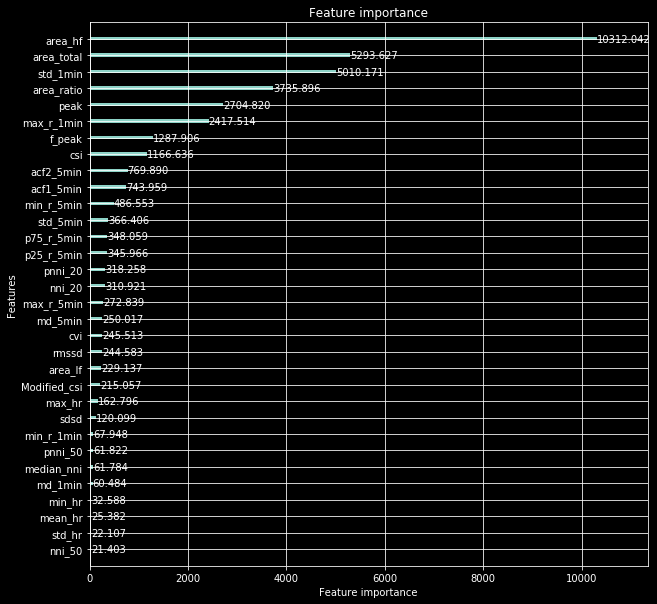

In [45]:
boost_round = 1000                   
early_stop_rounds = 50

params = {
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': ['auc'],
    'num_leaves': 2,   
    'learning_rate': 0.04,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.2,
    'bagging_freq': 1,
    'verbose': 0
}

results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_val, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results,
                verbose_eval=False
               )

y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_val, num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(metrics.accuracy_score(y_train,y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(metrics.accuracy_score(y_val,y_pred_test>0.5)))

lgb.plot_metric(results)
lgb.plot_importance(gbm,importance_type = "gain", figsize=(10,10))

In [2]:
#================================================================================
# 五，保存模型
#================================================================================
printlog("step5: saving model ...")

model_dir = "data/gbm.model"
print("model_dir: %s"%model_dir)
gbm.save_model("data/gbm.model")
printlog("task end...")